In [ ]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pickle
from collections import Counter
import multiprocessing as mp
import tqdm
from IPython import display
import time
import re

# Loading datasets and combining them into one

In [ ]:
all_images = []
all_labels = []

## Face Mask Detection and Medical Mask Dataset

In [ ]:
mask_detection_ann_path = '/content/drive/MyDrive/MaskDetection/Face Mask Detection/annotations'
mask_detection_image_path = '/content/drive/MyDrive/MaskDetection/Face Mask Detection/images'

medical_train_ann_path = '/content/drive/MyDrive/MaskDetection/Medical Mask Dataset/Dataset/Medical_Masks_Dataset/xml_labels'
medical_train_image_path = '/content/drive/MyDrive/MaskDetection/Medical Mask Dataset/Dataset/Medical_Masks_Dataset/images'
medical_test_ann_path = '/content/drive/MyDrive/MaskDetection/Medical Mask Dataset/Dataset/Medical_Masks_Dataset/test_images/test_xml_labels'
medical_test_image_path = '/content/drive/MyDrive/MaskDetection/Medical Mask Dataset/Dataset/Medical_Masks_Dataset/test_images'

ann_paths = [mask_detection_ann_path, medical_train_ann_path, medical_test_ann_path]
image_paths = [mask_detection_image_path, medical_train_image_path, medical_test_image_path] 

In [ ]:
def read_from_xml(name):

  labels = []
  images = []

  path = ann_path + '/' + name
  with open(path, 'r') as file:
      ann = file.read()
      soup = soup = BeautifulSoup(ann)

      image_name = soup.find('filename').text
      path = image_path + '/' + image_name
      image = Image.open(path)
      image = np.array(image)

      objects = soup.findAll('object')
      for obj in objects:
          label = obj.find('name').text
          labels.append(label)

          xmin = int(obj.find('xmin').text)
          ymin = int(obj.find('ymin').text)
          xmax = int(obj.find('xmax').text)
          ymax = int(obj.find('ymax').text)

          obj_image = image[ymin:ymax, xmin:xmax]
          images.append(obj_image)
    
  return images, labels

In [ ]:
def get_data(ann_path, image_path):
    
    names = os.listdir(ann_path)

    pool = mp.Pool(mp.cpu_count())
    images = []
    labels = []
    for result in tqdm.tqdm(pool.map(read_from_xml, names), total=len(names)):
      display.clear_output(wait=True)
      images += result[0]
      labels += result[1]
  
    return images, labels

In [ ]:
start = time.time()
for ann_path, image_path in zip(ann_paths, image_paths):
    images, labels = get_data(ann_path, image_path)
    all_images += images
    all_labels += labels
print(time.time() - start)

100%|██████████| 8/8 [00:00<00:00, 794.06it/s]

44.74001932144165


In [ ]:
len(all_images)

7986

## Face mask detector(mask ,not mask, incorrect mask)

In [ ]:
detector_incorrect_path = '/content/drive/MyDrive/MaskDetection/Face mask detector(mask ,not mask, incorrect mask)/dataset/incorrect_mask'
detector_mask_path = '/content/drive/MyDrive/MaskDetection/Face mask detector(mask ,not mask, incorrect mask)/dataset/with_mask'
detector_no_mask_path = '/content/drive/MyDrive/MaskDetection/Face mask detector(mask ,not mask, incorrect mask)/dataset/without_mask'

paths = [detector_incorrect_path, detector_mask_path, detector_no_mask_path]
regex = ['incorrect.+', '[0-9]+-with.+', '^[0-9]+.+']
label = ['incorrect', 'with_mask', 'without_mask']

In [ ]:
def get_image(name):
  image_path = path + '/' + name
  image = Image.open(image_path)
  image = np.array(image)

  return image

In [ ]:
def get_original_data(path, regex, label):
    names = os.listdir(path)
    print('\nFound', len(names), 'images')
    regex = re.compile(regex)
    names = list(filter(regex.match, names))
    print('Selected', len(names), 'images\n')
    
    images = []

    pool = mp.Pool(mp.cpu_count())
    for image in tqdm.tqdm(pool.map(get_image, names), total=len(names)):
      display.clear_output(wait=True)
      images.append(image)    
    
    labels = [label for i in range(len(names))]
    
    return images, labels

In [ ]:
start = time.time()
results = []
for path, reg, lab in zip(paths, regex, label):
    images, labels = get_original_data(path, reg, lab)
    all_images += images
    all_labels += labels

print('\n',time.time()-start)

100%|██████████| 408/408 [00:00<00:00, 1255.33it/s]


 10.040553569793701


In [ ]:
len(all_images)

8903

## facemask

In [ ]:
facemask_path = '/content/drive/MyDrive/MaskDetection/facemask'

In [ ]:
def get_images_paths(input_path):
    images_paths = []
    if input_path[-1] != '/':
        input_path += '/'
    
    items = os.listdir(input_path)
    for item in items:
        if not os.path.isdir(item):
            images_paths.append(input_path + item)
        else:
            images_paths.extend(get_images_paths(input_path + item))
    
    return images_paths

In [ ]:
def get_image(path):
  image = Image.open(path)
  image = np.array(image)
  images.append(image)
  
  label = path.split('/')[-2]
  labels.append(label)

  return image, label  

In [ ]:
paths = get_images_paths(path)

images = [] 
labels = []
pool = mp.Pool(mp.cpu_count())
for result in tqdm.tqdm(pool.map(get_image, paths), total=len(paths)):
  display.clear_output(wait=True)
  image = result[0]
  label = result[1]
  all_images.append(image)
  all_labels.append(label)

100%|██████████| 686/686 [00:00<00:00, 1236.79it/s]


In [ ]:
len(all_images)

9589

# Unification of labels

In [ ]:
np.unique(all_labels)

array(['bad', 'good', 'incorrect', 'mask_weared_incorrect', 'none',
       'with_mask', 'without_mask'], dtype='<U21')

In [ ]:
labels_dict = {
    'bad' : 'without_mask', 
    'good' : 'with_mask', 
    'incorrect' : 'incorrect',
    'mask_weared_incorrect' : 'incorrect',
    'none' : 'incorrect', 
    'with_mask' : 'with_mask',
    'without_mask' : 'without_mask'}

all_labels = [labels_dict[label] for label in all_labels]

# Resizing images to one size

In [ ]:
heights = [image.shape[0] for image in all_images]
widths = [image.shape[1] for image in all_images]
channels = [image.shape[2] for image in all_images if len(image.shape) == 3]

In [ ]:
Counter(heights).most_common()[:10]

[(428, 434),
 (18, 173),
 (433, 164),
 (19, 159),
 (20, 152),
 (22, 149),
 (23, 145),
 (17, 141),
 (24, 133),
 (21, 131)]

(array([7.529e+03, 8.460e+02, 9.550e+02, 1.170e+02, 3.200e+01, 7.000e+01,
        7.000e+00, 2.200e+01, 9.000e+00, 2.000e+00]),
 array([   2. ,  161.8,  321.6,  481.4,  641.2,  801. ,  960.8, 1120.6,
        1280.4, 1440.2, 1600. ]),
 <a list of 10 Patch objects>)

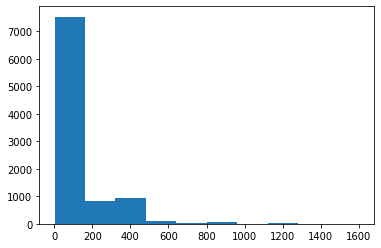

In [ ]:
plt.hist(heights)

In [ ]:
Counter(widths).most_common()[:10]

[(320, 537),
 (14, 175),
 (18, 175),
 (17, 164),
 (23, 153),
 (15, 152),
 (16, 145),
 (13, 143),
 (22, 142),
 (20, 134)]

(array([7.629e+03, 1.438e+03, 3.070e+02, 7.400e+01, 4.600e+01, 3.500e+01,
        6.000e+00, 1.100e+01, 1.800e+01, 2.500e+01]),
 array([1.0000e+00, 1.6090e+02, 3.2080e+02, 4.8070e+02, 6.4060e+02,
        8.0050e+02, 9.6040e+02, 1.1203e+03, 1.2802e+03, 1.4401e+03,
        1.6000e+03]),
 <a list of 10 Patch objects>)

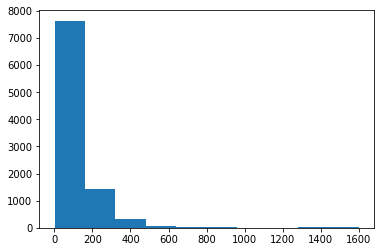

In [ ]:
plt.hist(widths)

In [ ]:
Counter(channels)

Counter({3: 5555, 4: 4033})

**For most networks from tf.keras.applications the image size cannot be smaller than 32 or 75, so images will be resized to 80x80.**

In [ ]:
def resize_image(image, new_shape=(80,80)):
  #delete 4-th channel
  if len(image.shape) == 3 and image.shape[-1] == 4:
    image = image[:,:,:-1]
  #resize
  image = Image.fromarray(image)
  image = image.resize(new_shape)
  image = np.array(image)
  return image

In [ ]:
resized_images = []

pool = mp.Pool(mp.cpu_count())
for image in tqdm.tqdm(pool.map(resize_image, all_images), total=len(all_images)):
  display.clear_output(wait=True)
  resized_images.append(image)

100%|██████████| 9589/9589 [00:11<00:00, 862.20it/s]


In [ ]:
#remove images with wrong number of channels
bad_indices = []
for i in range(len(resized_images)):
  image = resized_images[i]
  if len(image.shape) != 3 or image.shape[-1] != 3:
    bad_indices.append(i)

print(len(bad_indices))

for idx in bad_indices:
  del resized_images[idx]
  del all_labels[idx]

1


In [ ]:
all_images = np.array(resized_images)
all_labels = np.array(all_labels)

# Drop duplicates

In [ ]:
print('Before:', len(all_images))

Before: 9588


In [ ]:
uniques = np.unique(all_images, return_index=True, axis=0)
unique_images = all_images[uniques[1]]
unique_labels = all_labels[uniques[1]]

In [ ]:
print('After:', len(unique_images))

After: 9126


# Dataset preview

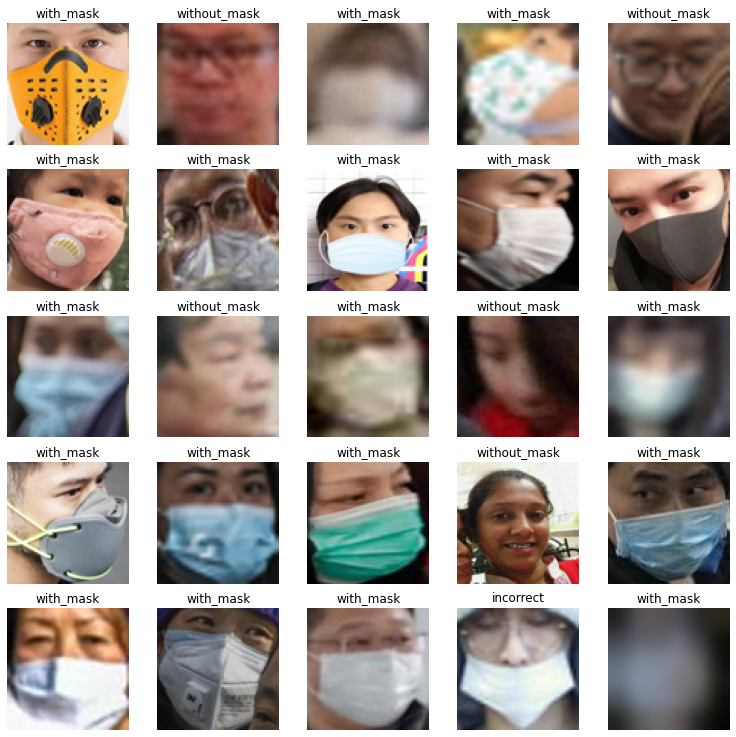

In [ ]:
n = 25

random_indices = np.random.choice(len(unique_labels), size=n, replace=False)
plt.figure(figsize=(13,13))
for i, idx in enumerate(random_indices):
    image = unique_images[idx]
    label = unique_labels[idx]
    
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
plt.show()

# Saving the dataset

In [ ]:
unique_images.shape

(9126, 80, 80, 3)

In [ ]:
np.save('/content/drive/MyDrive/MaskDetection/images.npy', unique_images)
np.save('/content/drive/MyDrive/MaskDetection/labels.npy', unique_labels)

# Checking class sizes

In [91]:
np.unique(unique_labels, return_counts=True)

(array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12'),
 array([ 348, 6759, 2019]))